# PHASE RESPONSE CA3

We will test the phase response of neurons firing at a fixed rate. To test this, we will make a network of 100 HH neurons, which are going to be stimulated with a fixed input current, that forces them to produce spikes steadily. Then, we will stimulate them in different times and record the delays between the inter-spike intervals.

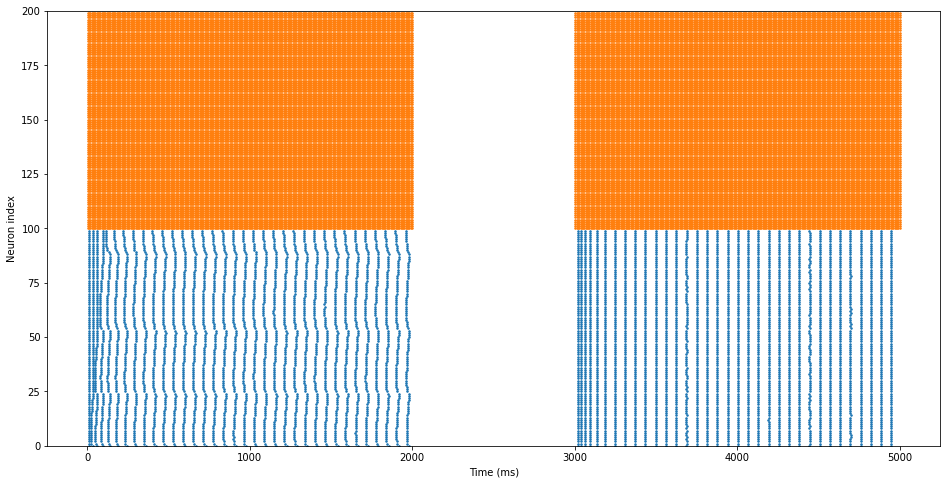

In [1]:
# Import brian2
from brian2 import *

# HH equations
# Pyramidal CAN
py_CAN_inp_eqs = '''
    dv/dt = (- I_CAN - I_M - I_leak - I_K - I_Na - I_Ca + I_exc + I_stim) / ((1.*ufarad*cm**-2) * (size)) + noise: volt
    I_CAN = ((gCAN) * (size)) * mCAN**2 * (v + 20.*mV) : amp
        dmCAN/dt = (mCANInf - mCAN) / mCANTau : 1
            mCANInf = alpha2 / (alpha2 + (0.0002*ms**-1)) : 1
            mCANTau = 1. / (alpha2 + (0.0002*ms**-1)) / (3.0**((36. - 22.) / 10.)) : second
            alpha2 = (0.0002*ms**-1) * (Ca_i / (5e-4*mole*metre**-3))**2 : Hz
    I_M = ((gM) * (size)) * p * (v - Ek) : amp
        dp/dt = (pInf - p) / pTau : 1
            pInf = 1. / (1. + exp(- (v + 35.*mV) / (10.*mV))) : 1
            pTau = (1000.*ms) / (3.3 * exp((v + 35.*mV) / (20.*mV)) + exp(- (v + 35.*mV) / (20.*mV))) : second
    I_leak = ((1e-5*siemens*cm**-2) * (size)) * (v - (-70.*mV)) : amp
    I_K = ((5*msiemens*cm**-2) * (size)) * (n**4) * (v - Ek) : amp
        dn/dt = alphan * (1 - n) - betan * n : 1
            alphan = 0.032 * (mV**-1) * (5.*mV) / exprel(-(v + 40.*mV) / (5.*mV)) / ms : Hz
            betan = 0.5 * exp(- (v + 45.*mV) / (40.*mV)) / ms : Hz
    I_Na = ((50*msiemens*cm**-2) * (size)) * (m**3) * h * (v - 50.*mV) : amp
        dm/dt = alpham * (1 - m) - betam * m : 1
            alpham = 0.32 * (mV**-1) * (4.*mV) / exprel(-(v + 42.*mV) / (4.*mV)) / ms : Hz
            betam = 0.28 * (mV**-1) * (5.*mV) / exprel( (v + 15.*mV) / (5.*mV)) / ms : Hz
        dh/dt = alphah * (1 - h) - betah * h : 1
            alphah = 0.128 * exp(- (v + 38.*mV) / (18.*mV)) / ms : Hz
            betah = 4. / (1. + exp(- (v + 15.*mV) / (5.*mV))) / ms : Hz
    I_Ca = ((1e-4 * siemens*cm**-2) * (size)) * (mCaL**2) * hCaL * (v - 120.*mV) : amp
        dmCaL/dt = (alphamCaL * (1. - mCaL)) - (betamCaL * mCaL) : 1
            alphamCaL = 0.055 * (mV**-1) * (3.8*mV) / exprel(-(v + 27.*mV) / (3.8*mV)) / ms : Hz
            betamCaL = 0.94 * exp(-(v + 75.*mV) / (17.*mV)) / ms : Hz
        dhCaL/dt = (alphahCaL * (1. - hCaL)) - (betahCaL * hCaL) : 1
            alphahCaL = 0.000457 * exp(-(v + 13.*mV) / (50.*mV)) / ms : Hz
            betahCaL = 0.0065 / (exp(-(v + 15.*mV) / (28.*mV)) + 1.) / ms : Hz
        dCa_i/dt = driveChannel + ((2.4e-4*mole*metre**-3) - Ca_i) / (200.*ms) : mole*meter**-3
            driveChannel = (-(1e4) * I_Ca / (cm**2)) / (2. * (96489*coulomb*mole**-1) * (1*umetre)) : mole*meter**-3*Hz

    dCl/dt = - Cl / tau_Cl : 1
    

    noise = sigma_noise_exc * (2. * (0.1e-3*siemens) / (1.*ufarad))**.5 * randn() / sqrt(tstep) : volt/second (shared, constant over dt)


    I_exc : amp
    r : 1
    I_stim = inputs_stim(t-i*10*tstep) : amp
    size : metre**2 (shared)
'''

inh_inp_eqs = '''
    dv/dt = ( - I_leak - I_K - I_Na - I_SynE - I_SynExt - I_SynHipp - I_SynI + I_exc + r*I_stim) / ((1.*ufarad*cm**-2) * (size)) + noise: volt
    Vm = (- I_leak - I_K - I_Na) / ((1*ufarad*cm**-2) * (size))*tstep : volt
    I_leak = ((0.1e-3*siemens*cm**-2) * (size)) * (v - (-65.*mV)) : amp
    I_K = ((9e-3*siemens*cm**-2) * (size)) * (n**4) * (v - (-90.*mV)) : amp
        dn/dt = (alphan * (1 - n) - betan * n) / 0.2: 1
            alphan = 0.1 / exprel(-0.1*(mV**-1)*(v + 34.*mV)) /ms : Hz
            betan = 0.125 * exp( - (v + 44.*mV) / (80.*mV)) / ms : Hz
    I_Na = ((35e-3*siemens*cm**-2) * (size)) * (m**3) * h * (v - (55.*mV)) : amp
        dm/dt = (alpham * (1 - m) - betam * m) / 0.2 : 1
            alpham = 1. / exprel(-(v + 35.*mV) / (10.*mV)) / ms : Hz
            betam = 4. * exp(- (v + 60.*mV) / (18.*mV)) / ms : Hz
        dh/dt = (alphah * (1 - h) - betah * h) / 0.2 : 1
            alphah = 0.07 * exp(- (v + 58.*mV) / (20.*mV)) / ms : Hz
            betah = 1. / (exp((- 0.1 * (mV**-1)) * (v + 28.*mV)) + 1.) / ms : Hz
    I_SynE = + ge * (v - 0.*mV) : amp
        dge/dt = (-ge+he) * (1. / (0.3*ms)) : siemens
        dhe/dt = -he/(5.*ms) : siemens
    I_SynExt = + ge_ext * (v - 0.*mV) : amp
        dge_ext/dt = (-ge_ext+he_ext) * (1. / (0.3*ms)) : siemens
        dhe_ext/dt = -he_ext/(5.*ms) : siemens
    I_SynHipp = + ge_hipp * (v - 0.*mV) : amp
        dge_hipp/dt = (-ge_hipp+he_hipp) * (1. / (0.3*ms)) : siemens
        dhe_hipp/dt = -he_hipp/(5.*ms) : siemens
    I_SynI = + gi * (v - (-80.*mV)) : amp
        dgi/dt = (-gi+hi) * (1. / (1.*ms)) : siemens
        dhi/dt = -hi/(10.*ms) : siemens


    noise = sigma_noise_inh * (2. * (0.1e-3*siemens ) / (1*ufarad))**.5 * randn() / sqrt(tstep) : volt/second (constant over dt)


    I_exc : amp
    r : 1
    I_stim = inputs_stim(t-i*10*tstep) : amp
    size : metre**2 (shared)
'''


# Spike and reset
reset_eqs = '''
    Cl = Cl + 0.2
'''

# Simulation
duration = 2*second
dt = 0.1*ms
defaultclock.dt = dt


# Model parameters
tau_Cl = 0.1*second # removal rate of chloride ions in excitatory cells; healthy 0.1s
Ek = -100.*mV # resting potential of potassium channels in excitatory cells; healthy -100mV
gM = 90.*usiemens*cmetre**-2 # conductance for M-current
gCAN = 0.25*usiemens*cmeter**-2 # wakefulness -> table 3.6, page 59, Aussel

cell_size_py = 29.e3*umetre**2
cell_size_inh = 14.e3*umetre**2

sigma_noise_exc = 0* 100.*uvolt # NOISE OFF
sigma_noise_inh = 0.*uvolt

tstep = defaultclock.dt
V_th = -20.*mvolt # spiking threshold
refractory_time = 3.*ms # refractory time after a spike

# Make a group of neurons
G_E = NeuronGroup(N=100,
    model=py_CAN_inp_eqs,
    threshold='v>V_th',
    reset=reset_eqs,
    refractory=refractory_time,
    method='exponential_euler',
    name='E_pyCAN')
G_E.size = cell_size_py
G_E.v = -60.*mV
G_E.I_exc = 0.5*nA
G_E.r = 0
G_E.r[0] = 0

# Make a group of neurons
G_I = NeuronGroup(N=100,
    model=inh_inp_eqs,
    threshold='v>V_th',
    refractory=refractory_time,
    method='exponential_euler',
    name='EC_inh')
G_I.size = cell_size_inh
G_I.v = -60.*mV
G_I.I_exc = 0.5*nA
G_I.r = 0
G_I.r[0] = 0

# Make the input
inputs_array = zeros((100,1))
inputs_stim = TimedArray(([0.]*10 + [5.] + [0.])*nA, dt=10*tstep)

# Create monitors
Mv_E = StateMonitor(G_E, 'v', record=True)
Mv_I = StateMonitor(G_I, 'v', record=True)

Ms_E = SpikeMonitor(G_E)
Ms_I = SpikeMonitor(G_I)

# Make the network
net = Network()
net.add(G_E, G_I, Mv_E, Ms_E, Mv_I, Ms_I)

# Test the E network
G_E.I_exc = 0.5*nA
G_I.I_exc = 0.5*nA
net.run(2*second)

G_E.I_exc = 0.*nA
G_I.I_exc = 0.*nA
net.run(1*second)

G_E.I_exc = 0.5*nA
G_I.I_exc = 0.5*nA
net.run(2*second)

# Plotting
fig = figure(figsize=(16,8))
plot(Ms_E.t/ms, Ms_E.i, '.C0', ms=3)
plot(Ms_I.t/ms, Ms_I.i+100, '.C1', ms=3)
ylim(0, 2*G_E.N)
xlabel('Time (ms)')
ylabel('Neuron index');

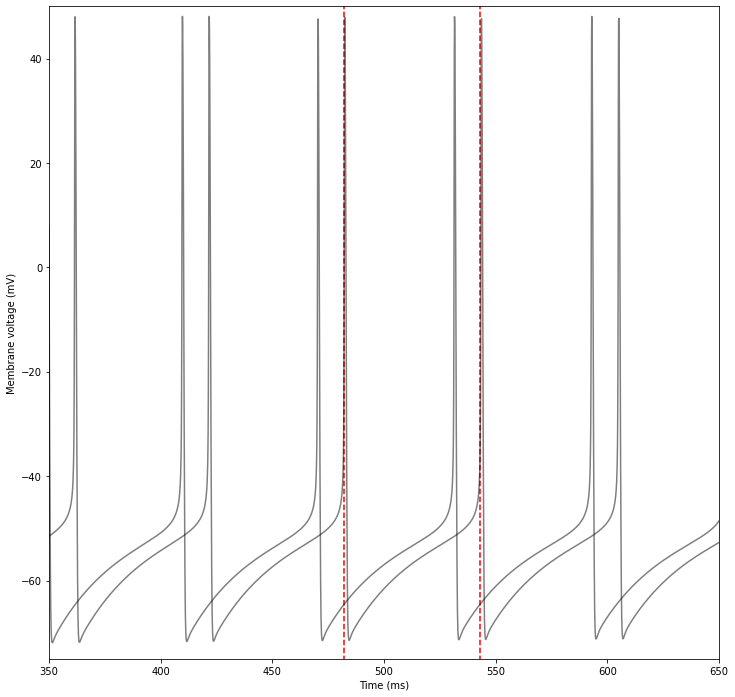

In [2]:
fig2, ax2 = plt.subplots(1, figsize=(12, 12))
idx1 = 52
idx2 = 55
ax2.plot(Mv_E.t/ms, Mv_E.v[idx1]/mV, c='k', alpha=0.5)
ax2.plot(Mv_E.t/ms, Mv_E.v[idx2]/mV, c='k', alpha=0.5)

ax2.vlines(x=Ms_E.t[np.where(Ms_E.i==idx1)[0][10:11]]/ms, ymin=-80, ymax=50, colors='red', linestyles='--')
ax2.vlines(x=Ms_E.t[np.where(Ms_E.i==idx1)[0][11:12]]/ms, ymin=-80, ymax=50, colors='red', linestyles='--')

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Membrane voltage (mV)')

ax2.set_ylim(-75, 50)
ax2.set_xlim(350, 650)
plt.show()

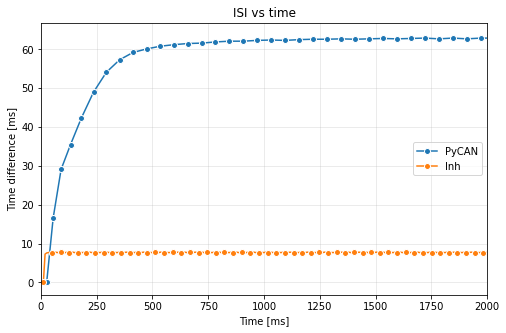

In [18]:
idx_E = np.where(Ms_E.i == 15)[0]
tdiff_E = (Ms_E.t[idx_E[1:]] - Ms_E.t[idx_E[0:-1]])/ms
tdiff_E[where(tdiff_E>75)] = 0
tdiff_E = np.insert(tdiff_E, 0, 0)
#print(Ms_E.t[idx])

idx_I = np.where(Ms_I.i == 15)[0]
tdiff_I = (Ms_I.t[idx_I[1:]] - Ms_I.t[idx_I[0:-1]])/ms
tdiff_I[where(tdiff_I>75)] = 0
tdiff_I = np.insert(tdiff_I, 0, 0)

fig3,ax3 = plt.subplots(figsize=(8,5))
ax3.plot(Ms_E.t[idx_E[1:]]/ms, tdiff_E[0:-1], 'C0o-', markevery=1, markersize=6.0, markerfacecolor='C0', mec='1.0', label='PyCAN')
ax3.plot(Ms_I.t[idx_I[1:]]/ms, tdiff_I[0:-1], 'C1o-', markevery=5, markersize=6.0, markerfacecolor='C1', mec='1.0', label='Inh')
ax3.set_title('ISI vs time')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Time difference [ms]')
ax3.set_xlim(0,2000)

ax3.legend(loc=5)
ax3.grid(ls='-', linewidth=0.5, alpha=0.5)

fig3.savefig('SpikeTimeDiff.png')